# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ ] YES - make available
* [X] NO - keep private

# Overview

In [1]:
# TODO

# Names

- Mariam Bachar (A16217374)
- Alexandra Hernandez (A16730685)
- Brian Kwon (A16306826)
- Andrew Uhm (A16729684)
- Ethan Wang (A17229824)

<a id='research_question'></a>
# Research Question

Do certain keywords as identified by CLIP correlate with the popularity (as measured by the equivalent of “likes”) that artwork receives on social media?

<a id='background'></a>

## Background & Prior Work

With the rise of social media in the past decade, Internet users are constantly exposed to different types of media, especially digital art. To interact with them, users can  “like” and “comment” on another’s content, which also notifies the owner of their received feedback. In turn, the algorithm not only encourages users to continue seeing content from the original user, but also similar “liked” content from different users (Lua, 2023). As a result, social media algorithms–despite having the same code throughout–are customized to each user, showing them content that is relevant to them, based on their past interactions with other accounts and users. Furthermore, these processes incorporate machine learning algorithms, such as feature detection and sentiment classification to better pinpoint content and users that an individual will most likely interact with, boosting engagement for both the receiving user–and the social media itself (T.K. et al., 2021).

As social media continues to grow, there continues to be several cases done on the usage of social media algorithms and their role in user engagement. Especially with the introduction of new feature detection technologies–and Artificial Intelligence (AI)–the study field has developed exponentially. In Radion Purba et. al. 's “Instagram Post Popularity Trend Analysis and Prediction” (2020) they looked into social media popularity predictions for marketing purposes; particularly, their research methodology discussed provided a similar workflow to our posed research question. They also discussed definitions of popularity, derived from the data collected. However, the main difference is the study done using hashtags (Radion Purba et al., 2020); we would incorporate AI-generated descriptions of relevant artwork. Similarly, Kafritsas's “CLIP: The Most Influential AI Model from OpenAI and How To Use It” (2022)  details the AI software we plan to use for our data generation. It involves the  AI, CLIP, showcasing  examples of its function, and describes common use cases. CLIP is not necessarily as accurate as other supervised learning models and lacks some context interpreting ability. As we plan to use similar AI technologies in our research, Kafritsas’s usage of CLIP primes us for its use in a concise manner while also precautions us on making certain assumptions when making our analyses.

**References**
1. Lua, A. (2023, April 20). How the Instagram Algorithm Works in 2023: Everything You Need to Know. Buffer Library; Buffer Library. https://buffer.com/library/instagram-feed-algorithm/#how-does-the-instagram-algorithm-work-the-6-key-ranking-factors

2. T.K., B., Annavarapu, C. S. R., & Bablani, A. (2021). Machine learning algorithms for social media analysis: A survey. Computer Science Review, 100395. https://doi.org/10.1016/j.cosrev.2021.100395

3. Radion Purba, K., Asirvatham, D., & Kumar Murugesan, R. (2020). Instagram Post Popularity Trend Analysis and Prediction using Hashtag, Image Assessment, and User History Features. The International Arab Journal of Information Technology, 1. https://doi.org/10.34028/iajit/18/1/10

4. Kafritsas, N. (2022). CLIP: The Most Influential AI Model From OpenAI — And How To Use It. Medium; Towards Data Science. https://towardsdatascience.com/clip-the-most-influential-ai-model-from-openai-and-how-to-use-it-f8ee408958b1

# Hypothesis


We predict that digital artwork that contains certain keywords as predicted by CLIP (painting vs. watercolor vs. digital) will indeed have a positive correlation to popularity on social media. As humans observing what is popular, we notice that certain features tend to repeat themselves across posts, which leads us to believe a correlation will be found.

# Dataset(s)

- Dataset Name: deviation_info
- Link to the dataset: https://github.com/COGS108/Group_Sp23_Project_Group_3/blob/master/deviation_info.csv
- Number of observations: 1188

This dataset is a set of deviations (that is images from deviantart) that contain deviation ids and metadata about the deviation itself as well as the author. It does not include the actual images.

- Dataset Name: caption_info
- Link to the dataset: https://github.com/COGS108/Group_Sp23_Project_Group_3/blob/master/caption_info.csv
- Number of observations: 1188

This dataset is a set of captions processed from the image, corresponding to a deviation id. It was processed using the CLIP interrogator in Automatic1111's stable diffusion webui.

- Dataset Name: images
- Link to the dataset: https://github.com/COGS108/Group_Sp23_Project_Group_3/tree/master/images
- Number of observations: 1198

This dataset is a directory of images in png format that are named based on their corresponding deviation ids, it contains the actual images. There are 10 extra images in here that aren't found in our other datasets.

All of the datasets were built from scraping, and use deviation ids as their identifiers. Because of this, we can easily add them together based on those deviation ids if necessary.

# Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata

import requests
import urllib
from bs4 import BeautifulSoup
import deviantart

import time
from datetime import datetime
from pathlib import Path

import json
from PIL import Image
import base64
import cv2

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import math
import random
import statsmodels.api as sm
import patsy

from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# DeviantArt API: https://www.deviantart.com/developers/http/v1/20210526
# Open-Source Python wrapper for DA API: https://github.com/neighbordog/deviantart

In [3]:
# creates a pd df from the CSV file if it exists, else creates a blank df.
csv_file = 'deviation_info.csv'
try:
    deviation_df = pd.read_csv(csv_file)
except FileNotFoundError:
    deviation_df = pd.DataFrame()

# Data Cleaning

First, we'll do some basic cleaning where we drop N/A values and duplicates.

In [4]:
# if new session, retrieve our deviation info
csv_file = 'deviation_info.csv'
try:
    deviation_df = pd.read_csv(csv_file)
except:
    FileNotFoundError
    
# if new session, retrieve our CLIP caption info
csv_file = 'caption_info.csv'
try:
    caption_df = pd.read_csv(csv_file)
except FileNotFoundError:
    caption_df = pd.DataFrame()

Let's join our dataframes together based on their common ID for easier usage later:

In [5]:
# joining the two dataframes for good measure.
df = pd.merge(deviation_df, caption_df, on='Deviation ID', how='inner')
df.head()

,Deviation ID,Title,Author,Views,Favorites,Comments,URL Link,Date Posted,Height,Width,File Size,Author Watchers,Author Page Views,Author Deviations,Caption
0,6797CD44-47EA-B405-9377-5D41D83F33FE,A l'aise...,thrumyeye,2022815,31101,2385,https://www.deviantart.com/thrumyeye/art/A-l-a...,2011-02-17 23:43:04,599,900,408379,36527,1354598,2179,a red fox is sitting in the grass and looking ...
1,83750DFB-D23E-00A3-DF4F-D164A07DF605,Tiger cub,Kamirah,1271452,20720,2097,https://www.deviantart.com/kamirah/art/Tiger-c...,2008-07-11 06:10:53,800,800,523370,45123,7500677,358,a tiger sitting on top of a rock in a forest w...
2,8F1ED8A1-88A5-861A-F83B-77916A1481A0,Baby Steps 0268P,Sooper-Deviant,1097719,24050,937,https://www.deviantart.com/sooper-deviant/art/...,2009-10-05 06:55:37,400,400,4493241,35586,1438276,345,a red panda cub walking on a tree branch in th...
3,66D5BA39-C0D4-7A95-52FF-C0694149142E,Sky Turtle,yuumei,1056323,23103,918,https://www.deviantart.com/yuumei/art/Sky-Turt...,2014-01-23 10:46:57,532,1000,390864,397714,22504533,842,a bird flying through the air with its wings s...
4,1C127EBF-EFF7-7BC4-004D-0355A2856C05,Riders,sandara,1240225,15643,512,https://www.deviantart.com/sandara/art/Riders-...,2013-09-30 23:37:02,770,1200,832434,212588,7566524,796,a man riding on the back of a horse next to a ...


We want to anonymize the data to maintain ethical integrity as discussed in our project proposal. Let's remove the Author field, as it doesn't contribute anything otherwise. We don't need the URL anymore and it also reveals the author on top of that, so we remove it too. We are essentially using the caption in place of the title, so we will disregard it. We also acknowledge that webpage "views" can be manipulated by bots. The views on the deviation (read: artwork) are still relevant despite knowing that, but the views on the Author's page matter less so. Let's remove that also:

In [6]:
df = df.drop('URL Link', axis=1)
df = df.drop('Author', axis=1)
df = df.drop('Author Page Views', axis=1)
df = df.drop('Title', axis=1)

In [7]:
df.head()

,Deviation ID,Views,Favorites,Comments,Date Posted,Height,Width,File Size,Author Watchers,Author Deviations,Caption
0,6797CD44-47EA-B405-9377-5D41D83F33FE,2022815,31101,2385,2011-02-17 23:43:04,599,900,408379,36527,2179,a red fox is sitting in the grass and looking ...
1,83750DFB-D23E-00A3-DF4F-D164A07DF605,1271452,20720,2097,2008-07-11 06:10:53,800,800,523370,45123,358,a tiger sitting on top of a rock in a forest w...
2,8F1ED8A1-88A5-861A-F83B-77916A1481A0,1097719,24050,937,2009-10-05 06:55:37,400,400,4493241,35586,345,a red panda cub walking on a tree branch in th...
3,66D5BA39-C0D4-7A95-52FF-C0694149142E,1056323,23103,918,2014-01-23 10:46:57,532,1000,390864,397714,842,a bird flying through the air with its wings s...
4,1C127EBF-EFF7-7BC4-004D-0355A2856C05,1240225,15643,512,2013-09-30 23:37:02,770,1200,832434,212588,796,a man riding on the back of a horse next to a ...


We can justify the rest of the columns. We need the ID for identification purposes. The title may relate to the CLIP caption. The views, favorites, and comments are how we are gauging the popularity of the post. The date posted is relevant for trend analysis. The file size, height, and width implies the rendering definition (e.g. 1080px) of the work. Author watchers and deviations may imply how much experience or traction this author has had on DeviantArt. Finally, the CLIP caption is integral to our hypothesis.

Now we consider adjusting the string-based content of our data. Below we notice that the AI caption is longer than we need it to be:

In [8]:
for n in range(0, 1000, 200):
    print(df['Caption'][n])
    print()

a red fox is sitting in the grass and looking at the camera with a sad look on its face, Arie Smit, animal photography, a stock photo, furry art

a drawing of a bunch of arrows with different designs on them and numbers on them, all of which are different, Évariste Vital Luminais, tarot card, concept art, symbolism

a painting of a winged creature standing in a forest next to a lake with a waterfall in the background, Bastien Lecouffe-Deharme, magic the gathering artwork, concept art, fantasy art

a drawing of a umbrella and a clock on a book page with a pen and ink drawing of a woman holding an umbrella, Farel Dalrymple, illustrated, a storybook illustration, pop surrealism

a drawing of a woman with blue hair and a blue eyeliner on a notebook with a pen and a pen, Android Jones, trending on art station, a watercolor painting, process art



Notice that mainly what is before the first comma is the only relevant part of the caption. Furthermore, the AI makes a guess at who made the picture after the first comma. Let's remove everything after the first comma:

In [9]:
for n in range(df['Caption'].size):
    before_comma = df['Caption'][n].split(",")[0]
    df.loc[n, 'Caption'] = before_comma

In [10]:
df['Caption'][30]

'a forest with a lot of trees and snow on the ground and sun shining through the trees and the ground'

Now the caption is much more precise. However, we do not want the stopwords such as "a", "is", "the", etc. within our analysis, as they are irrelevant. Let's remove them:

In [11]:
stopwords = set(stopwords.words('english'))

In [12]:
for n in range(df['Caption'].size):
    tokens = word_tokenize(df['Caption'][n])
    filtered_text = [word for word in tokens if word not in stopwords]
    if "'s" in filtered_text:
        filtered_text.remove("'s")
    filtered_text = list(set(filtered_text))
    filtered_caption = ' '.join(filtered_text)
    df.loc[n, 'Caption'] = filtered_caption

In [13]:
df['Caption'][30]

'ground trees sun forest snow shining lot'

This will do.

# Data Analysis & Results

The first step of our Data Analysis would be to determine the popularity metric by using views, favorites, and comments fields. This way, we can dive deeper into our analysis and explore 3 main popularity trends: fileSizeAndQuality, authorExperience, and the AICaption.

Next, we will run a statistical test to see whether popularity IS NOT related to fileSizeAndQuality or authorExperience, and if popularity IS related to the AICaption. It's not critical that these statistical tests pass, rather we just need the results to evaluate whether our hypothesis is true or false;

We predict that digital artwork that contains certain keywords as predicted by CLIP (painting vs. watercolor vs. digital) will indeed have a positive correlation to popularity on social media. As humans observing what is popular, we notice that certain features tend to repeat themselves across posts, which leads us to believe a correlation will be found.

We first need to define a popularity metric in order to do meaningful analysis. We explore the views, favorites, comments, and author watcher fields to get an idea of what a reasonable metric to measure popularity would look like.

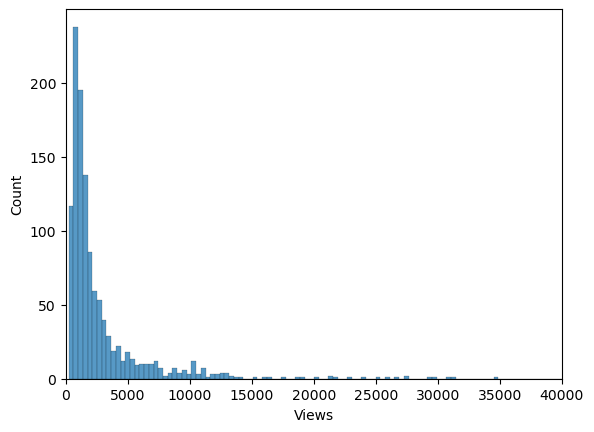

In [14]:
sns.histplot(df['Views']/100)
plt.xlim(0, 40000)
plt.show()

The plot shown above is a histogram of the artwork views divided by 100. The x-axis represents the range of views, while the y-axis represents the frequency or count of artworks falling within each range. The majority of artworks fall between 0 and 5000 views.

In terms of the research question and hypothesis, the histogram provides an overview of the distribution of artwork views on social media. By examining the histogram, we can analyze the relationship between the popularity of artwork (measured by views) and the keywords present in the artwork captions.

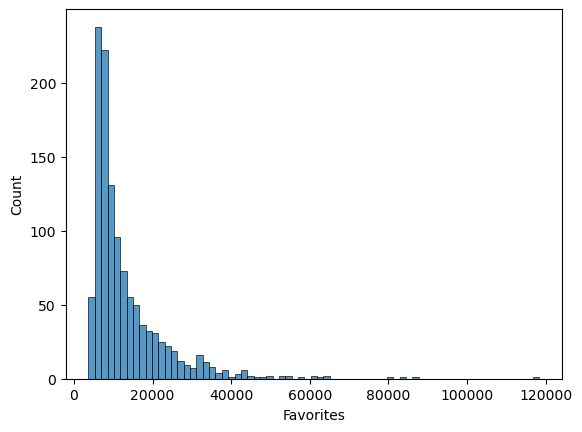

In [15]:
sns.histplot(df['Favorites'])
plt.show()

The plot shown is a histogram of the number of favorites (equivalent to "likes") received by the artworks. The histogram allows us to examine the relationship between the popularity of the artworks (measured by the number of favorites) and the keywords present in their captions. The x-axis represents the range of favorites, while the y-axis represents the frequency or count of artworks falling within each range. As one can see, majority of art received favorites between 5000 to 15000.

By looking at the histogram, we can gain insights into how artworks are being received by the audience in terms of favorites. The distribution of favorites can indicate whether certain artworks are more popular or resonate better with the viewers.

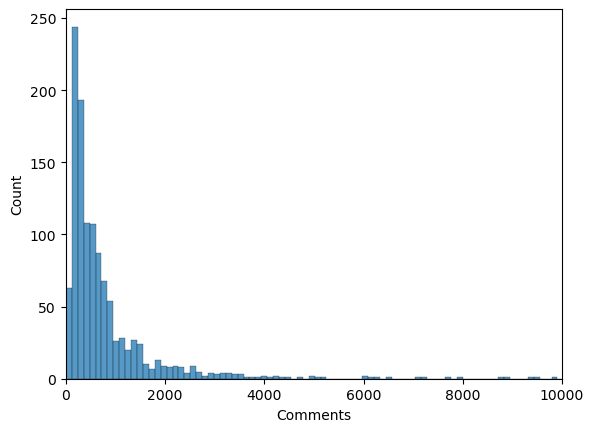

In [16]:
sns.histplot(df['Comments'])
plt.xlim(0, 10000)
plt.show()

The plot shown is a histogram of the number of comments received by the artworks. Similar to the previous plot, the x-axis represents the range of comments, while the y-axis represents the frequency or count of artworks falling within each range, with the majority falling between 0 and 1000 comments.

Analyzing this plot in relation to the research question and hypothesis, it provides an overview of the distribution of comments received by the artworks on social media. The histogram allows us to examine the relationship between the engagement level of the artworks (measured by the number of comments) and the keywords present in their captions.

We notice that the distribution for views, favorites, and comments are all similar but differ obviously on the scale. There are a handful of outliers here and there (two points at around 10 million and 6 million are excluded in the views plot and around 5 points above 10 thousand were excluded in the comments plot), but for the most part most people do not get a lot of interaction on their posts (which is how popularity intuitively works).

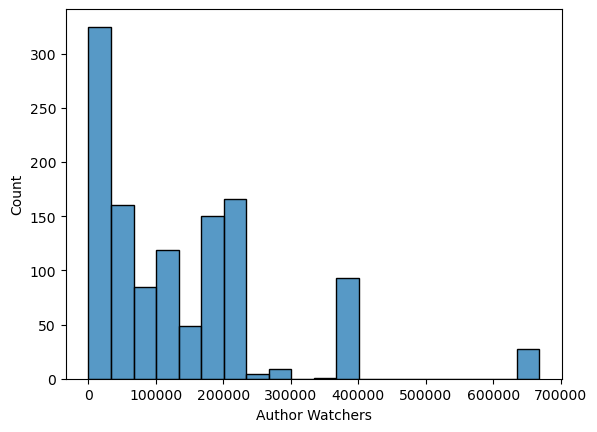

In [17]:
sns.histplot(df['Author Watchers'])
plt.show()

Author distribution is certainly not normal but not necessarily as clearly right-skewed as the popularity metrics.

We note that to put the popularity distributions on a similar scale, we can use the scale factors below:

In [18]:
view_scale_factor = 0.01
favorite_scale_factor = 1.0
comment_scale_factor = 10.0

Finally we can divide by Author Watcher count to normalize popularity based on how large a following an author already has (and thus has contributed to the popularity of the artwork):

In [19]:
popularity_metrics = []
for n in range(df.shape[0]):
    view_count = df['Views'][n]
    favorite_count = df['Favorites'][n]
    comment_count = df['Comments'][n]
    watcher_count = df['Author Watchers'][n]
    popularity_metric = (view_count*view_scale_factor + favorite_count*favorite_scale_factor + comment_count*comment_scale_factor) / watcher_count
    popularity_metrics.append(popularity_metric * 10)

In [20]:
popularity_metric_df = pd.DataFrame(popularity_metrics).rename(columns={0: 'Popularity Metric'})
popularity_metric_df.describe()

,Popularity Metric
count,1188.000000
mean,46.593045
std,340.959089
min,0.134138
25%,0.723449
50%,1.690288
75%,7.912631
max,6759.395455


In [21]:
df = pd.concat([df, popularity_metric_df], axis=1)

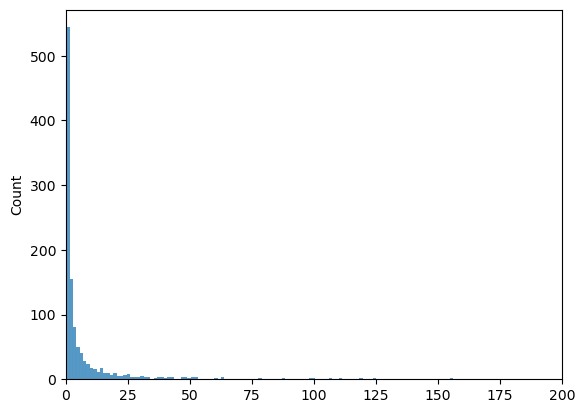

In [22]:
sns.histplot(popularity_metrics)
plt.xlim(0, 200)
plt.show()

We still have some pretty wild outliers. Let's try applying a logarithm to the data to normalize further:

In [23]:
df['LogPopMetric'] = np.log1p(df['Popularity Metric'])

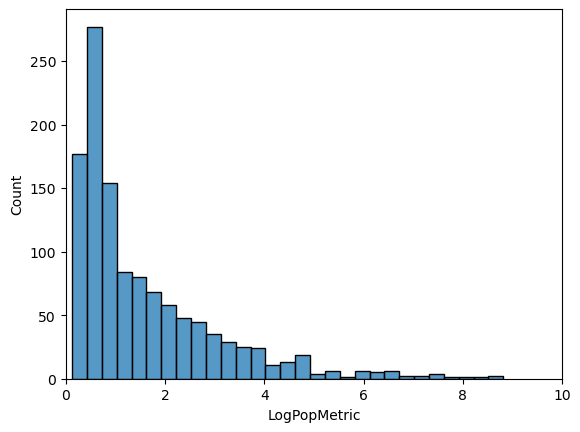

In [24]:
sns.histplot(df['LogPopMetric'])
plt.xlim(0, 10)
plt.show()

That seriously helped. Now that we've made a best attempt at normalizing our popularity data, we want to convert it into rank statistics, as popularity data is inherently ordinal in nature if we're sampling starting from the most popular. We'll use scipy's rankdata and append that to our dataframe:

In [25]:
# flip ranks so we get the highest metric = rank 1
ranks = len(df) + 1 - rankdata(df['LogPopMetric'])
df['Rank'] = ranks

In [26]:
df.head(3)

,Deviation ID,Views,Favorites,Comments,Date Posted,Height,Width,File Size,Author Watchers,Author Deviations,Caption,Popularity Metric,LogPopMetric,Rank
0,6797CD44-47EA-B405-9377-5D41D83F33FE,2022815,31101,2385,2011-02-17 23:43:04,599,900,408379,36527,2179,grass sad face sitting camera red look looking...,20.581803,3.071850,166.0
1,83750DFB-D23E-00A3-DF4F-D164A07DF605,1271452,20720,2097,2008-07-11 06:10:53,800,800,523370,45123,358,top forest sitting around flowers neck leaves ...,12.056938,2.569320,236.0
2,8F1ED8A1-88A5-861A-F83B-77916A1481A0,1097719,24050,937,2009-10-05 06:55:37,400,400,4493241,35586,345,forest cub walking tree red branch panda,12.476027,2.600912,232.0


Just as a curiosity, let's order by ranking and see some of the most popular (as defined by us, of course) works:

In [27]:
sorted_df = df.sort_values('Rank').reset_index(drop=True)
sorted_df.head(4)

,Deviation ID,Views,Favorites,Comments,Date Posted,Height,Width,File Size,Author Watchers,Author Deviations,Caption,Popularity Metric,LogPopMetric,Rank
0,AF3C97E9-AC22-5FC2-200A-9F7DD0DF4E32,165801,26104,1685,2006-11-03 22:12:37,56,99,16277,66,109,planet pluto either quote picture caption 's,6759.395455,8.818837,1.0
1,60740003-A0C3-5C99-5B55-A7C90A33EB70,2985059,23246,6544,2007-10-14 19:57:15,56,99,4778,202,171,characters two picture stamp different,5868.148020,8.677465,2.0
2,921BD7C7-0F3E-4102-993C-89EB397F409D,95259,11764,729,2009-01-13 12:31:37,55,99,6993,40,100,real music face says quote background picture ...,5001.647500,8.517723,3.0
3,BB8400B2-75DA-4876-178E-91C0516EBEA0,263967,5051,593,2006-07-13 01:29:25,450,540,178631,46,2,trees lit snow christmas covered night tree ba...,2961.015217,7.993625,4.0


planet pluto either quote picture caption 's


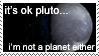

In [28]:
# deviation with the highest popularity metric
most_popular_id = sorted_df.loc[0][0]
most_popular_index = sorted_df[sorted_df['Deviation ID'] == f'{most_popular_id}'].index[0]
print(sorted_df[sorted_df['Deviation ID'] == f'{most_popular_id}'].loc[most_popular_index][10])
display(Image(filename=f'./images/{most_popular_id}.png', width=300))

trees lit snow christmas covered night tree background fence


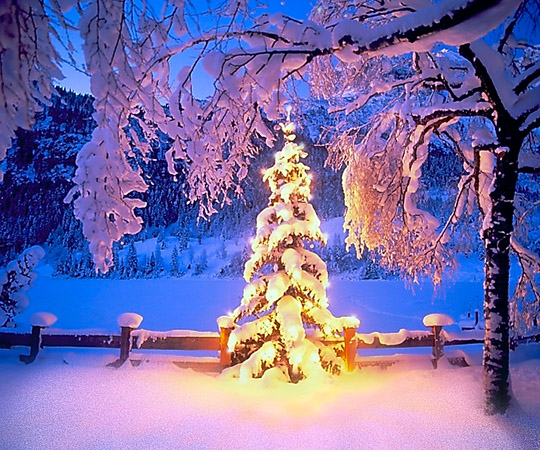

In [29]:
# deviation with the fourth highest popularity metric
# ...choosing the fourth since second and third place are both also "stamp" memes like the most popular
second_most_popular_id = sorted_df.loc[3][0]
second_most_popular_index = sorted_df[sorted_df['Deviation ID'] == f'{second_most_popular_id}'].index[0]
print(sorted_df[sorted_df['Deviation ID'] == f'{second_most_popular_id}'].loc[second_most_popular_index][10])
display(Image(filename=f'./images/{second_most_popular_id}.png', width=400))

In order to observe the data and to see the effects of keywords on popularity, we decided to aggregate all of the popularity data into a single dataframe with only the popularity values paired with keywords. In order to determine the popularity of a keyword, we decided to take the average of the popularities of each keyword and use that value to determine the overall popularity. We also removed all words that appeared less than 3 times in order to remove some inconsistent words that had high popularity rankings that appeared very few times. In order to do this, we used the values from the dictionary unique to create the new dataframe. We also did a log on the data in order to further deal with outliers.

First let's store the keywords and popularity statistics into one dictionary:

In [30]:
# unique is a dict that contains a list of tuples of (Deviation ID, Popularity Metric, Rank) for each unique word in our df.
# the frequency of a key (word) is the length.
unique = {}
for n in range(df.shape[0]):
    tokens = word_tokenize(df['Caption'][n])
    for word in tokens:
        if word in unique:
            unique[word].append((df['Deviation ID'][n], df['LogPopMetric'][n], df['Rank'][n]))
        else:
            # tuple that contains (freq, deviation ID)
            unique[word] = [(df['Deviation ID'][n], df['LogPopMetric'][n], df['Rank'][n])]

In [31]:
# for example:
unique['branch']

[('8F1ED8A1-88A5-861A-F83B-77916A1481A0', 2.6009123357311243, 232.0),
 ('A77528CF-7D8B-734F-09FF-A20F273E1F1F', 2.081393865649798, 317.0),
 ('7FCBF6C1-783A-4AE4-8322-9991CD34253A', 1.9199322899300628, 351.0),
 ('7E879736-6DBA-5262-6935-8D22F87D8AED', 0.7386174042420426, 726.0),
 ('5C1F6B9A-2224-E9B4-D7BA-4DB93FE0FEDD', 0.9502397749725155, 620.0),
 ('6F78458E-4DCA-C156-2566-AE328D9EB766', 1.599436595899893, 421.0),
 ('0086BEF0-C182-912F-7CB2-1D743B720A99', 2.543928685816548, 241.0),
 ('FFC323F3-B917-3DC2-77BB-5242E98BE18D', 1.5294458965703184, 439.0),
 ('CC7A161D-CF1F-B0C9-8D29-D963389B209C', 0.8643744327390998, 670.0),
 ('75993019-BCDB-7871-83D2-F041ABC813CD', 0.23762916176767612, 1175.0),
 ('5E0C9B16-41D4-3108-8F1D-127FFBCECE06', 1.6314723637090305, 415.0),
 ('AA879A6F-958B-28D4-3DDA-FB1180CDA983', 0.6481572008207315, 807.0),
 ('46FE4F99-5800-E659-DC5A-42004B32C686', 0.3745802529619545, 1084.0),
 ('CC01191D-DAB5-C75D-1654-CF4CA0E1DA83', 1.0380303075514539, 576.0),
 ('386964D4-B1EA-BE4

Let's find a way to get the overall popularity of a word in another dictionary, "word_popularity". For the raw popularity metric we will take an average of a unique word's associated deviation (log) popularity list. Rank has no such issues, so we'll just average it.

In [32]:
word_popularity = {}
for word in unique:
    pop_met_sum = 0
    rank_sum = 0
    for popular_tuple in unique[word]:
        deviation_id, pop_met, rank = popular_tuple
        pop_met_sum += pop_met
        rank_sum += rank
    total_unique = len(unique[word])
    pop_met_sum /= total_unique
    rank_sum /= total_unique
    word_popularity[word] = (pop_met_sum, rank_sum)

In [33]:
# for example:
word_popularity['branch']

(1.2955293454059411, 664.3809523809524)

Let's look at a plot of what we have before continuing.

<Axes: ylabel='Count'>

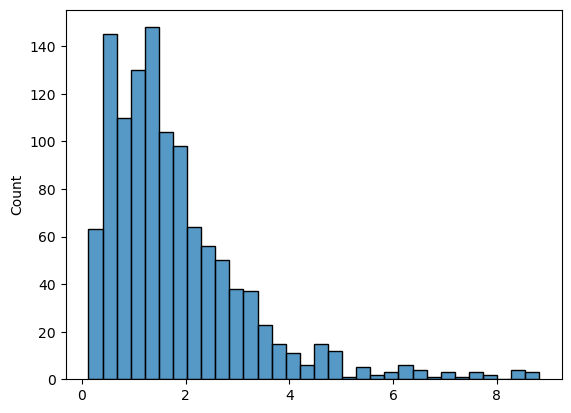

In [34]:
# a histplot that plots the frequency of avg logpopmet values for our words
logpopmet = [val[0] for val in word_popularity.values()]
sns.histplot(logpopmet)

We notice that... [data is still ordinal]

<Axes: ylabel='Count'>

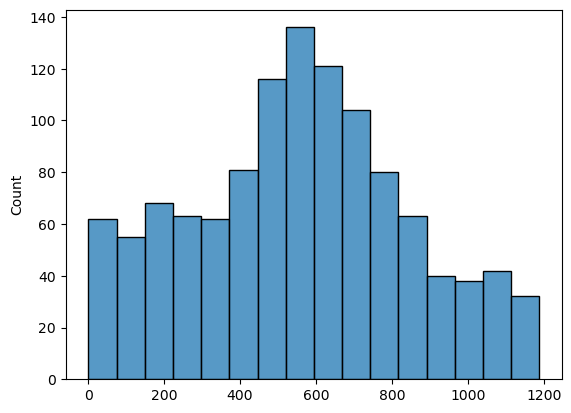

In [35]:
# a histplot that plots the frequency of avg ranks for our words
ranks_for_hist = [val[1] for val in word_popularity.values()]
sns.histplot(ranks_for_hist)

We notice that when analyzing our data by rank, it follows a more Gaussian distribution. This is perhaps to be expected, since when data is ordinalized, it's probably more likely that a word will cover a group of deviations that have a more average rank to begin with.

Let's look at the spread and variance of our data to see if words seem to accurately predict popularity. In other words, let's see if the range and standard deviation of popularity for a single word is significantly smaller than the range and standard deviation overall.

In [68]:
# here is the overall stdev and range
print('standard deviation is', np.std(df['LogPopMetric']))
print('range is', np.ptp(df['LogPopMetric']))

standard deviation is 1.4533664214416036
range is 8.692963816284498


In [69]:
count = 0
n = 5 # only analyze words that are related to >= n posts to get meaningful
logpop_stats = {}
rank_stats = {}
for word in unique:
    if len(unique[word]) >= n:
        count += 1
        logpop_data = [val[1] for val in unique[word]]
        logpop_stats[word] = (np.std(logpop_data), np.ptp(logpop_data))
        
        rank_data = [val[2] for val in unique[word]]
        rank_stats[word] = (np.std(rank_data), np.ptp(rank_data))
print(count)

334


In [70]:
#logpop_stats # standard dev, range

Text(0, 0.5, 'Values that have a certain SD')

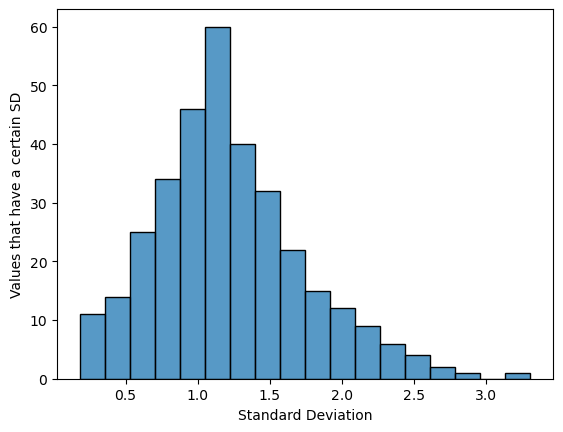

In [71]:
logpop_std_stats = [val[0] for val in logpop_stats.values()]
np.mean(logpop_std_stats)

sns.histplot(logpop_std_stats)
plt.xlabel('Standard Deviation')
plt.ylabel('Values that have a certain SD')

This is our distribution of standard deviations. Our standard deviation indicates how volatile a term is in popularity, if terms directly correlated to popularity we would expect all the terms to have a very low standard deviation. Our graph shows us that the standard deviation looks somewhat like a normal distribution, but that there is also a left skew. A left skew supports our hypothesis because it means that many terms do correlate with popularity, more than we'd expect from randomness (perfectly normal), but to really test this we need to perform a t-test.

In [72]:
#A note about this: I don't know if this test is the correct test. For one this is a derived distribution, and may not
#fill the criteria to even run a t test on it. Intuitively the stuff above seems correct, but it's hard to say without
#a test of statistical significance. I also looked into a chi square test, but it seems invalidated because it's derived.
test_statistic, p_value = stats.wilcoxon(logpop_std_stats)
print("p Value:", p_value)

p Value: 1.6741921358573887e-56


In [73]:
logpop_range_stats = [val[1] for val in logpop_stats.values()]
logpop_range_stats[:5]

[5.988498877068574,
 3.5087521074860124,
 8.271814145895242,
 6.21630392725329,
 3.488594920943672]

In [74]:
np.ptp(df['LogPopMetric'])

8.692963816284498

In [75]:
np.std(df['LogPopMetric'])

1.4533664214416036

In order to answer our hypothesis (whether keywords are an indication of popularity), we need to ask how it is possible to use our data in order to answer our hypothesis. Our data contains 

## Machine Learning
In order to answer our hypothesis, we need to ask how it is possible to use our data in order to answer our hypothesis. The nature of our data consists of word/value pairings. 

In [44]:
# setting up vectorizers
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        analyzer='word', 
                        tokenizer=word_tokenize, 
                        stop_words='english')

count = CountVectorizer(analyzer='word',
                        tokenizer=word_tokenize,
                        stop_words='english')

# scramble the dataframe so that we don't have any bias based on ordering
scrambled_df = df.sample(frac=1.0)
training_df = df

training_tfidf = pd.DataFrame(tfidf.fit_transform(training_df['Caption'].tolist()).toarray(), 
                             index=training_df['Deviation ID'], 
                             columns=tfidf.get_feature_names_out())
training_count = pd.DataFrame(count.fit_transform(training_df['Caption'].tolist()).toarray(),
                             index=training_df['Deviation ID'],
                             columns=count.get_feature_names_out())

# setting up two decision tree regressors
tfidfTree = DecisionTreeRegressor()
countTree = DecisionTreeRegressor()

# setting up Lasso and SGD models better suited for sparse space
tfidfLasso = Lasso()
countLasso = Lasso()

# tfidfSGD = SGDRegressor()
# countSGD = SGDRegressor()

# setting a linear regression model
linearModel = LinearRegression()

In [45]:
# this section was written with the help of ChatGPT
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the input features and output target
X = training_tfidf
y = training_df['Popularity Metric']

# Perform k-fold cross-validation and calculate RMSE
k = 10  # Number of folds
scoring = 'neg_root_mean_squared_error'

# tree models
tfidfTree_scores = cross_val_score(tfidfTree, training_tfidf, y, cv=k, scoring=scoring)
countTree_scores = cross_val_score(countTree, training_count, y, cv=k, scoring=scoring)

# lasso and SGDmodels
tfidfLasso_scores = cross_val_score(tfidfLasso, training_tfidf, y, cv=k, scoring=scoring)
countLasso_scores = cross_val_score(countLasso, training_count, y, cv=k, scoring=scoring)

# linear model
linear_scores = cross_val_score(linearModel, training_tfidf, y, cv=k, scoring=scoring)

# Define the K-Fold cross-validation object
kf = KFold(n_splits=k)

# Perform k-fold cross-validation for the mean baseline
mean_baseline_scores = []
for train_index, test_index in kf.split(X):
    y_train = y[train_index]
    y_test = y[test_index]
    mean_baseline_score = mean_squared_error(y_test, np.full_like(y_test, y_train.mean())) ** 0.5
    mean_baseline_scores.append(mean_baseline_score)

# Calculate the mean baseline score across all folds
mean_baseline_score_avg = np.mean(mean_baseline_scores)

# Calculate the average RMSE across all folds
print("Negative Root Mean Squared Error:")
print("Tree TF-IDF: ", -np.mean(tfidfTree_scores))
print("Tree Count: ", -np.mean(countTree_scores))
print("Lasso TF-IDF: ", -np.mean(tfidfLasso_scores))
print("Lasso Count: ", -np.mean(countLasso_scores))
print("Linear TF-IDF: ", -np.mean(linear_scores))
print("Mean Baseline: ", mean_baseline_score_avg)

Negative Root Mean Squared Error:
Tree TF-IDF:  293.67266998088695
Tree Count:  294.0675884693095
Lasso TF-IDF:  267.9340451897202
Lasso Count:  263.6585152083669
Linear TF-IDF:  568545840854804.5
Mean Baseline:  267.25942911929184


Here we tried a multitude of models to see if we could achieve performance predicting the popularity better than a baseline of always guessing the mean. We did this using K-fold cross validation as there was high variance between models with different sections of the data.

Overall we found that Lasso stochastic coordinate descent with count vectorized tokens generally performed the best, and was able to sometimes slightly outperform the mean baseline. Being able to surpass the mean baseline means that our machine learning attempts do support our hypothesis, but likely not in a significant way since we only barely surpass the mean baseline possibly due to random chance, since it varies from performing slightly better to slightly worse.

In [46]:
print("Shape of vectorized tokens: ", training_count.shape)
print("\nPerformance of Count Lasso models: ")
print(-countLasso_scores)
print("\nPerformance of Always Choose Mean: ")
print(mean_baseline_scores)

Shape of vectorized tokens:  (1188, 1130)

Performance of Count Lasso models: 
[711.16724681 615.98194634 146.35192875 109.11127143 194.6105285
  68.01426788 179.11061282 289.20836847 202.76723483 120.26174626]

Performance of Always Choose Mean: 
[715.666174925987, 620.7851119772212, 154.90419599196088, 102.9266692092935, 217.9004835070109, 45.520830673522944, 183.55579938719228, 296.68537056211153, 204.3136925676096, 130.33596239100854]


Here we take a look at the shape of our model and the performance of the models across K-fold. We can see that there is high variance in the standard loss, varying from as high as 711.167 to as low as 68.014 for the Count Lasso model, and that it's able to sometimes eke out a slight advantage over the mean baseline.

The shape of our data is also problematic, as the number of rows is almost equal to the number of columns, which means we'd likely have to see a direct correlation for the model to improve performance significantly. 

Given the shape of our data, and the high variance of the performance, we conclude that we do not have sufficient data for machine learning attempts. Potentially, with feature engineering we could increase performance.

In [47]:
# analyzing lasso model by count vectorization features
lasso_model = Lasso()
lasso_model.fit(training_count, training_df['Popularity Metric'])

feature_importances = dict(zip(lasso_model.feature_names_in_, lasso_model.coef_))

sorted_tfidf_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print('10 most popular features: ')
for a in sorted_tfidf_importances[:10]:
    print(a)
print('\n10 least popular features: ')
for a in reversed(sorted_tfidf_importances[-10:]):
    print(a)

10 most popular features: 
('pluto', 4966.199942488235)
('stamp', 4557.928916200048)
('music', 3259.9789241656376)
('christmas', 1729.4047759565003)
('quote', 418.27356999713186)
('meme', 335.1089031895344)
('photo', 321.9760621723358)
('disco', 295.9902990340601)
('holes', 262.9380582882115)
('sleeping', 226.36144965383485)

10 least popular features: 
('drawing', -14.999208597662047)
('painting', -13.807872766427362)
('woman', -13.26676322949765)
('middle', -13.011823759739018)
('cartoon', -10.644528980549268)
('man', -9.73981251767227)
('standing', -9.056845379237298)
('red', -8.815054799887296)
('bunch', -6.509106695692984)
('sitting', -6.2066489549985935)


We can look at the features and their importance of a lasso model that we fit to the entire dataset. Here we can see that a lot of the outliers are represented as very important within our model. It's likely that the model's minute success isn't predicated on these high importance outliers, but on some combination (not necessarily all) of the other roughly 1100 features, and that within our k-fold validation data these terms simply don't show up enough to express a worse result due to overfitting.

As an example, taking all the values with 4 digit coefficients, we can see they only show up once within the data set:

In [48]:
print('Pluto:', unique['pluto'], '\nStamp:', unique['stamp'], '\nMusic:', unique['music'], '\nChristmas:', unique['christmas'])

Pluto: [('AF3C97E9-AC22-5FC2-200A-9F7DD0DF4E32', 8.818836666519113, 1.0)] 
Stamp: [('60740003-A0C3-5C99-5B55-A7C90A33EB70', 8.677464760857438, 2.0)] 
Music: [('921BD7C7-0F3E-4102-993C-89EB397F409D', 8.517722551280578, 3.0)] 
Christmas: [('BB8400B2-75DA-4876-178E-91C0516EBEA0', 7.993625132353812, 4.0)]


In [49]:
training_df = df
training_df = training_df.reset_index()

training_count = pd.DataFrame(count.fit_transform(training_df['Caption'].tolist()).toarray(),
                             columns=count.get_feature_names_out())

X = training_count.reset_index()
X = X.iloc[:, 1:]
X = sm.add_constant(X)
X, y = X.align(training_df['LogPopMetric'], axis=0)

statsmodel = sm.OLS(y, X)
result = statsmodel.fit()

print(result.f_pvalue)

1.4348476330667487e-07


Lastly, we ran ran an OLS regression model for inference on our vectorized input and popularity rating output, and received an incredibly small p-value for the F-test, which implies that having the independent variables (that is, the vectorized tokens) makes the model perform better than if there were no independent variables.

This strongly rejects the null hypothesis that subject as described by CLIP has no bearing on popularity, which supports our hypothesis that the subject as described by CLIP does, to some extent, determine popularity. This helps to validate the previous machine learning analysis.

It's important to note that statsmodel's OLS (ordinary least squares) model may not be the model best suited for analysis of sparse data, and does tend to vary likely due to the aforementioned problems with our data.

# Ethics & Privacy

There are a number of ethical concerns regarding this research question that we must be mindful of as we analyze data. The most obvious issue is that we are tagging artwork as unpopular by virtue of not identifying said artwork as popular. However, this should not be a strong issue as we are not presenting identifying pieces of information of specific pieces of artwork or individual artists, so it should not be possible to label a specific artwork or artist as “unpopular”.

In terms of normalization, a possible solution would be to take a ratio between the number of likes on the artwork and the number of followers that certain artist has in order to take into account the disparity between larger artists and smaller artists in terms of popularity, as more popular artists would get more likes due to a larger audience. Additionally, it is entirely possible that our analysis may exclude cultural influences of minority groups. Since those residing in developed countries have more leisure time/resources (such as drawing software or drawing e-tablets), it is plausible that most digital art posted to social media is likely from developed countries. Thus, the work we analyze may disproportionately represent artwork and cultural trends of majority groups of developed countries while glossing over minority groups, which tend to be similar across developed countries.

Finally, because the artworks are on a public forum, they have consented to allowing their art to be analyzed. The Deviantart TOS states that you cannot “reproduce, distribute, publicly display or perform, or prepare derivative works”, which does not include the use of the artworks for an analytic survey. Although there is no clear-cut solution for this, it serves us well to keep this fact in mind when drawing conclusions upon our analyses.

# Conclusion & Discussion

In [50]:
# TODO

# Team Contributions

**Mariam**
- Helped create the timeline for meetings and deadlines as outlined in project proposal
- Helped to interpret and write descriptions for statistic graphs for the EDA
- Contributed to research for project background
- Wrote and edited part of script for project video

**Alexandra** 
- Prepared/initialized the creation of the notebooks (outside of the template)
- Completed the project background for the Project Proposal and its proofreadings
- Wrote and edited part of script for project video
- Did descriptions for statistic graphs for the EDA

**Brian**
- Wrote the ethics and privacy portion of the Project Proposal
- Contributed to data analysis with keyword popularity statistics
- Helped with the video script and video creation
- Helped finalize the project document

**Andrew**
- Contributed to data extraction and generation
- Main work on data cleaning, making dataset ethically useable and applied natural language processing on AI generated captions
- Worked on construction of popularity metric
- Applied statistical analysis relevant to hypothesis testing

**Ethan**
- Contributed to data extraction and generation
- Main work on data extraction, scraping relevant data from Deviantart and processing the images to create captions
- Mostly worked on the data portion of the project proposal
- Mostly worked on the ML portion of the EDA